# Capstone: Development of an algorithm for automatic detection of meniscus tears in radiographic images of the knee.

### Contents:
- [Background](#Background)
- [Data](#Data)



In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
# Import libraries here
import os
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import random as random
import imageio
import imgaug as ia
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import save_img, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Average, Input, Activation, Reshape, TimeDistributed
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras import models, layers, utils
from tensorflow.keras import backend as K
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.utils import plot_model
pd.options.mode.chained_assignment = None  # default='warn'

tmpdir = tempfile.mkdtemp()


**Data from [MRNet](https://stanfordmlgroup.github.io/competitions/mrnet/):** 
* Images of 1370 knee MRI exams performed at Stanford University Medical Center. The dataset contains 1,104 (80.6%) abnormal exams,  with 319 (23.3%) ACL tears and 508 (37.1%) meniscal tears; labels were obtained through manual extraction from clinical reports. 
* train set: consists of 1130 MRI images from coronal, sagittal and transverse planes
* valdation set: consists of 120 MRI images from coronal, sagittal and transverse planes


## Data import

**import data and get labels**

In [ ]:
!unzip drive/My\ Drive/data.zip > /dev/null

In [ ]:
train_path = 'data/train/'
valid_path = 'data/valid/'

In [ ]:
datasets = {'train': train_path, 'valid': valid_path}
planes = ['axial', 'coronal', 'sagittal']
# diagnosis = ['abnormal','meniscus','acl']

In [ ]:
def get_data(dataset_type, plane, diagnosis):
    '''this function gets the data for each plane from original dataset'''
    # for eg, (train, sagittal, acl)
    if dataset_type == 'train':
        go = train_path
    else:
        go = valid_path
        
#     img_path = glob(f'{go}/{plane}/*.npy')
    plane_dir = f'{go}/{plane}'
    data = os.listdir(plane_dir)
    
    # label_path = f'../data/{dataset_type}-{diagnosis}.csv'
    label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])
    
    return(data, plane_dir, label_data)

**meniscus dataset**

In [ ]:
# training data
train_coronal_data, train_coronal_dir, train_men_label = get_data('train', 'coronal', 'meniscus')
train_axial_data, train_axial_dir, train_men_label = get_data('train', 'axial', 'meniscus')
train_sagittal_data, train_sagittal_dir, train_men_label = get_data('train', 'sagittal', 'meniscus')

In [ ]:
# validation data
valid_coronal_data, valid_coronal_dir, valid_men_label = get_data('valid','coronal','meniscus')
valid_axial_data, valid_axial_dir, valid_men_label = get_data('valid','axial','meniscus')
valid_sagittal_data, valid_sagittal_dir, valid_men_label = get_data('valid','sagittal','meniscus')

In [ ]:
train_coronal_data[0]

'0549.npy'

In [ ]:
train_coronal_dir

'data/train//coronal'

The dataset contains *s* x 256 x 256 images. Since middle images are the most useful, only 3 middle slides in the series are retained. 
<br> Unfortunately, when using a pretrained model, one is limited by input_shape. For VGG16, it should be (224, 244, 3), or (3, 224, 224). It should be in 4D tensor with shape (batch_shape, conv_dim1, conv_dim2, channel).

In [ ]:
def image_extraction(data, path, new_path): #3 images
    '''this function extracts middle 3 slides of each scan'''
    extract=[]
    new_data=[]
    for i in range(len(data)): 
        img = np.load(os.path.join(path,data[i]))
        middle_idx = int(img.shape[0]/2)
        img = img[(middle_idx - 1) : (middle_idx + 2)]
#         # reshape adapted for model (s x 256 x 256 x 1)
#         img = np.repeat(img[..., np.newaxis], 1, -1)
        img = img.reshape(256,256,3)
        extract.extend(img)
        new_data.append(np.array(extract))        
        extract.clear()
        
#     new_data.shape(1130, 256, 256, 3) for train
    np.save(new_path, np.array(new_data))


**image extraction for training data**

In [ ]:
# image extraction for 3 planes
new_path = 'data/train_transform/coronal'
image_extraction(train_coronal_data, train_coronal_dir, new_path)

In [ ]:
new_path = 'data/train_transform/axial'
image_extraction(train_axial_data, train_axial_dir, new_path)

In [ ]:
new_path = 'data/train_transform/sagittal'
image_extraction(train_sagittal_data, train_sagittal_dir, new_path)

In [ ]:
image = np.load('data/train_transform/sagittal.npy')

In [ ]:
image[0].shape

(256, 256, 3)

**extraction for validation data**

In [ ]:
# image extraction for 3 planes
new_path = 'data/valid_transform/coronal'
image_extraction(valid_coronal_data, valid_coronal_dir, new_path)

In [ ]:
new_path = 'data/valid_transform/axial'
image_extraction(valid_axial_data, valid_axial_dir, new_path)

In [ ]:
new_path = 'data/valid_transform/sagittal'
image_extraction(valid_sagittal_data, valid_sagittal_dir, new_path)

In [ ]:
image = np.load('data/valid_transform/sagittal.npy')
image.shape

(120, 256, 256, 3)

**data generation for meniscus**

In [ ]:
def data_gen(dataset_type, plane, diagnosis):
    '''this function gets the data for each plane from extracted dataset'''
    # for eg, (train, sagittal, mensicus)
    if dataset_type == 'train':
        go = 'data/train_transform/'
    else:
        go = 'data/valid_transform/'
        
    plane_dir = f'{go}/{plane}.npy'
    
    data = np.load(plane_dir)
    # label_path = f'../data/{dataset_type}-{diagnosis}.csv'
    label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])
    
    return(data, label_data)
    

In [ ]:
# generate training input
coronal_mensicus, coronal_mensicus_label = data_gen('train', 'coronal', 'meniscus')
axial_mensicus, axial_mensicus_label = data_gen('train', 'axial', 'meniscus')
sagittal_mensicus, sagittal_mensicus_label = data_gen('train', 'sagittal', 'meniscus')

# generate validation
coronal_mensicus_val, coronal_mensicus_label_val  = data_gen('valid', 'coronal', 'meniscus')
axial_mensicus_val, axial_mensicus_label_val  = data_gen('valid', 'axial', 'meniscus')
sagittal_mensicus_val, sagittal_mensicus_label_val  = data_gen('valid', 'sagittal', 'meniscus')

In [ ]:
def plot_results(model):
    '''this function plots the results of the model'''
    train_loss = model.history['loss']
    test_loss = model.history['val_loss']
    acc = model.history['accuracy']
    val_acc = model.history['val_accuracy']
    epoch_labels = model.epoch

    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)

    axes[0].plot(train_loss, label='Training Loss', color='#185fad')
    axes[0].plot(test_loss, label='Testing Loss', color='orange')

    axes[1].plot(acc, label='Training accuracy', color='blue')
    axes[1].plot(val_acc, label='Testing accuracy', color='red')

    # Set title
    axes[0].title.set_text('Training and Testing Loss by Epoch')
    axes[1].title.set_text('Training and Testing Accuracy by Epoch')
    axes[0].set_xlabel('Epoch')
    axes[1].set_xlabel('Epoch')
    axes[0].set_ylabel('Binary Crossentropy')
    axes[1].set_ylabel('Binary Crossentropy')
    plt.xticks(epoch_labels, epoch_labels);    
    axes[0].legend(fontsize=18);
    axes[1].legend(fontsize=18);


## Utilising pretrained model

### Resnet50


ResNet-50 is a convolutional neural network that is 50 layers deep. It was first introduced in 2015 ([He et al., 2015](https://arxiv.org/abs/1512.03385)), and become really popular after winning several classification competitions. Since it is FIFTY layers deep, the stacked layers can enrich the features of the models, however, it can also lead to degradation (ie, the accuracy layers may saturate and then slowly degrade after a point). Thus, model performance will deteriorate on both training and testing sets. 

In [ ]:
model = ResNet50(weights='imagenet')

# display architecture
print(model.summary())


102981632/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

In [ ]:
# train only the last black of the ResNet50
for layer in model.layers[:143]:
    layer.trainable = False
df = pd.DataFrame(([layer.name, layer.trainable] for layer in model.layers), columns=['layer', 'trainable'])
df.style.applymap(lambda trainable: f'background-color: {"yellow" if trainable else "white"}', subset=['trainable'])

,layer,trainable
0,input_1,False
1,conv1_pad,False
2,conv1_conv,False
3,conv1_bn,False
4,conv1_relu,False
5,pool1_pad,False
6,pool1_pool,False
7,conv2_block1_1_conv,False
8,conv2_block1_1_bn,False
9,conv2_block1_1_relu,False


In [ ]:
# https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/
image = load_img('/content/drive/MyDrive/knee0000.png',target_size=(224,224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
yhat = model.predict(image)
label = decode_predictions(yhat)
label = label[0][0]
print('%s (%.2f%%)' % (label[1], label[2]*100))


49152/35363 [=========================================] - 0s 0us/step
hook (58.98%)


Note that ImageNet has no class 'knee', so a random image was identified as a hook.

**ResNet50 model**

'include_top' argument is False, so that the fully-connected output layers of the model used to make predictions is not loaded, allowing a new output layer to be added and trained. 
Since 'include_top' argument is False, the 'input_tensor' argument must be specified, allowing the expected fixed-sized input of the model to be changed. 
Since there is no output layer, the 'pooling' argument will take the average output from the last layer directly. 


In [ ]:
def finetune_model(model_name, num_epochs, train_data, train_labels, validation_data, validation_labels):
    '''this function builds and runs the model'''
    # path_dir = r'C:\Users\USER\DSI-roughpaper\capstone\data' 
    # weights_path = f'{path_dir}\{model_name}\\resnet_weights.h5'
    path_dir = '/content/drive/MyDrive' 
    weights_path = f'{path_dir}/{model_name}/resnet_weights.h5'
    
    new_input = Input(shape=(256, 256, 3))
    model = ResNet50(weights='imagenet', include_top=False, input_tensor=new_input)
    
    add_model = Sequential()
    add_model.add(Flatten(input_shape=model.output_shape[1:]))
    add_model.add(Dropout(0.5))
    add_model.add(Dense(1, activation='sigmoid'))
#     add_model.load_weights(weights_path)
    
    final_model = Model(inputs=model.input, outputs=add_model(model.output))
    final_model.save_weights(weights_path)
    
    # weights will not be updated for the first 142 layers
    # only the last block will be trained with the added connected layers
    for layer in model.layers[:142]:
        layer.trainable = False

    sgd = optimizers.SGD(learning_rate=1e-4, decay=1e-6, momentum=0.9, nesterov=False)
    final_model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
    
    history = final_model.fit(x=train_data, y=np.array(train_labels), 
            batch_size=32, 
            validation_data=(validation_data, np.array(validation_labels)),
            epochs=num_epochs, 
            callbacks = [EarlyStopping(patience=3, monitor = 'val_loss', mode = 'min')],                  
            verbose=1)
    
    return final_model, history

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/20
36/36 [==============================] - 23s 441ms/step - loss: 1.2182 - accuracy: 0.5442 - val_loss: 1.0286 - val_accuracy: 0.5250
Epoch 2/20
36/36 [==============================] - 12s 338ms/step - loss: 0.5047 - accuracy: 0.7858 - val_loss: 1.1919 - val_accuracy: 0.5250
Epoch 3/20
36/36 [==============================] - 12s 338ms/step - loss: 0.2443 - accuracy: 0.8991 - val_loss: 1.1948 - val_accuracy: 0.5417
Epoch 4/20
36/36 [==============================] - 12s 339ms/step - loss: 0.1395 - accuracy: 0.9451 - val_loss: 1.2163 - val_accuracy: 0.4833


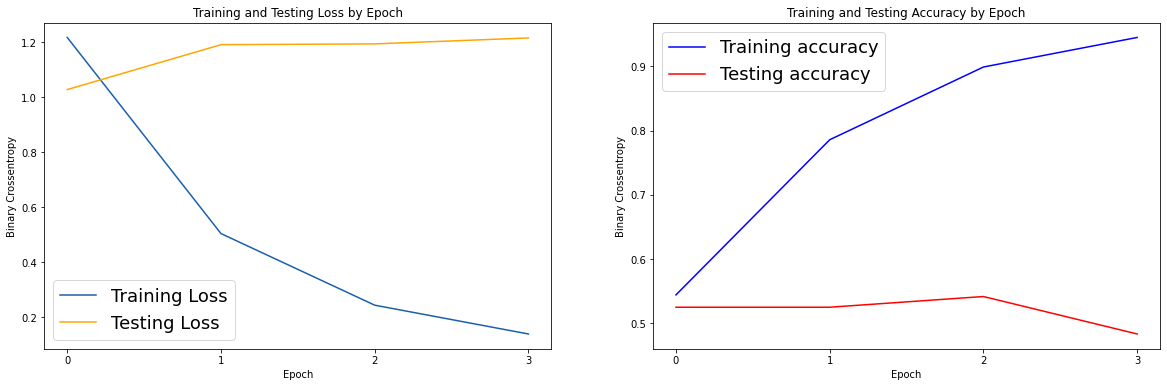

In [ ]:
# coronal plane
num_epochs=20

cor_men_model, resnet_cor_men = finetune_model('resnet_cor_men', num_epochs, coronal_mensicus, coronal_mensicus_label, coronal_mensicus_val, coronal_mensicus_label_val)

# get/plot accuracy
resnet_cor_men_acc=[]
resnet_cor_men_acc.append(np.mean(resnet_cor_men.history['val_accuracy']))
plot_results(resnet_cor_men)

Epoch 1/20
36/36 [==============================] - 18s 372ms/step - loss: 1.2617 - accuracy: 0.5531 - val_loss: 1.3047 - val_accuracy: 0.5750
Epoch 2/20
36/36 [==============================] - 12s 338ms/step - loss: 0.5389 - accuracy: 0.7938 - val_loss: 2.3404 - val_accuracy: 0.5667
Epoch 3/20
36/36 [==============================] - 12s 340ms/step - loss: 0.2976 - accuracy: 0.8788 - val_loss: 2.0351 - val_accuracy: 0.5500
Epoch 4/20
36/36 [==============================] - 12s 340ms/step - loss: 0.1374 - accuracy: 0.9442 - val_loss: 1.6769 - val_accuracy: 0.5083


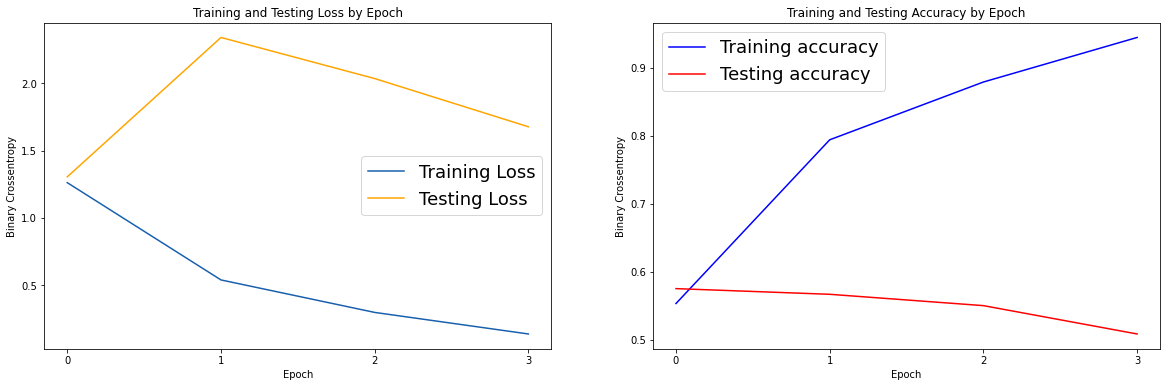

In [ ]:
# axial plane
num_epochs=20

axl_men_model, resnet_axl_men = finetune_model('resnet_axl_men', num_epochs, axial_mensicus, axial_mensicus_label, axial_mensicus_val, axial_mensicus_label_val)

# get/plot accuracy
resnet_axl_men_acc=[]
resnet_axl_men_acc.append(np.mean(resnet_axl_men.history['val_accuracy']))
plot_results(resnet_axl_men)

Epoch 1/20
36/36 [==============================] - 18s 372ms/step - loss: 1.1602 - accuracy: 0.5549 - val_loss: 1.0044 - val_accuracy: 0.5500
Epoch 2/20
36/36 [==============================] - 12s 337ms/step - loss: 0.4820 - accuracy: 0.7876 - val_loss: 1.4352 - val_accuracy: 0.5417
Epoch 3/20
36/36 [==============================] - 12s 338ms/step - loss: 0.1955 - accuracy: 0.9239 - val_loss: 1.3263 - val_accuracy: 0.5250
Epoch 4/20
36/36 [==============================] - 12s 339ms/step - loss: 0.1371 - accuracy: 0.9522 - val_loss: 1.3450 - val_accuracy: 0.5250


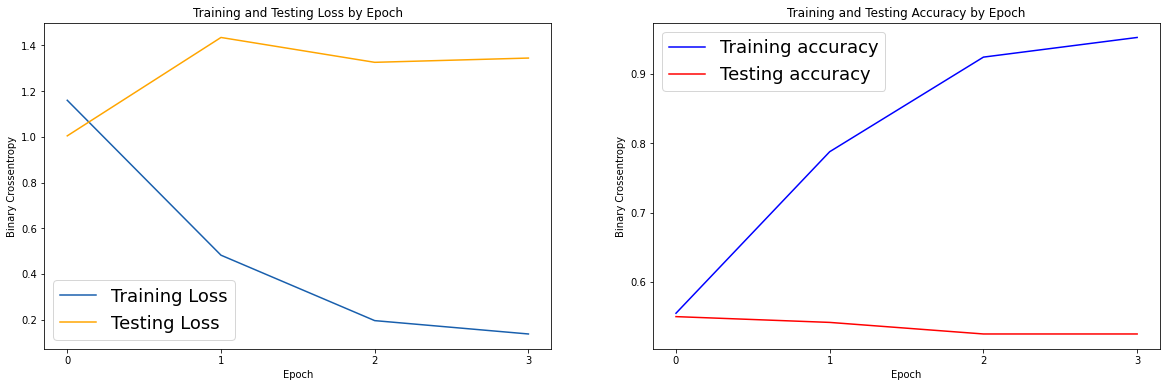

In [ ]:
# sagittal plane
num_epochs=20

sag_men_model, resnet_sag_men = finetune_model('resnet_sag_men', num_epochs, sagittal_mensicus, sagittal_mensicus_label, sagittal_mensicus_val, sagittal_mensicus_label_val)

# get/plot accuracy
resnet_sag_men_acc=[]
resnet_sag_men_acc.append(np.mean(resnet_sag_men.history['val_accuracy']))
plot_results(resnet_sag_men)

**calculate average accuracy**

In [ ]:
[resnet_cor_men_acc, resnet_axl_men_acc, resnet_sag_men_acc]

[[0.5187499895691872], [0.5499999970197678], [0.5354166626930237]]

### Evaluate results

In [ ]:
cor_men_scores = cor_men_model.evaluate(coronal_mensicus_val, np.array(coronal_mensicus_label_val), verbose=0)
print('Test loss:', cor_men_scores[0]) 
print('Test accuracy:', cor_men_scores[1])

Test loss: 1.2163481712341309
Test accuracy: 0.4833333194255829


In [ ]:
cor_pred = cor_men_model.predict(coronal_mensicus_val) 
axl_pred = axl_men_model.predict(axial_mensicus_val) 
sag_pred = sag_men_model.predict(sagittal_mensicus_val) 

In [ ]:
pred_men = pd.DataFrame(np.column_stack([cor_pred,axl_pred,sag_pred]),columns=['cor_pred', 'axl_pred', 'sag_pred'])
pred_men['mean'] = pred_men.mean(axis=1)

In [ ]:
# since model output is [0,1] using sigmoid activation function
# pred is the probability
# take average probability from all 3 planes
pred_men['mean']

0      0.060587
1      0.015899
2      0.298742
3      0.478385
4      0.324799
         ...   
115    0.275738
116    0.065842
117    0.592000
118    0.598934
119    0.345734
Name: mean, Length: 120, dtype: float32

In [ ]:
pred_men['mean'] = pred_men.mean(axis=1)

In [ ]:
# if prob<0.5, it is 0.
pred_men['predict'] = pred_men['mean'].map(lambda x: 0 if x<0.5 else 1)

In [ ]:
pred_men['predict'].value_counts()

0    110
1     10
Name: predict, dtype: int64

In [ ]:
# labels are same for all planes
pred_men['true'] = coronal_mensicus_label_val

In [ ]:
pred_men[pred_men['true'] != pred_men['predict']].shape

(54, 6)

In [ ]:
pred_men[pred_men['true'] != pred_men['predict']]

,cor_pred,axl_pred,sag_pred,mean,predict,true
30,0.678280,0.884166,0.309052,0.623832,1,0
40,0.632473,0.637166,0.744713,0.671451,1,0
42,0.786415,0.296782,0.044072,0.375757,0,1
43,0.250400,0.042604,0.077758,0.123588,0,1
44,0.405597,0.057516,0.352220,0.271778,0,1
46,0.320765,0.300918,0.009827,0.210503,0,1
47,0.780729,0.625496,0.867260,0.757828,1,0
54,0.184208,0.003906,0.159435,0.115850,0,1
55,0.941659,0.013883,0.731646,0.562396,1,0
56,0.137374,0.037195,0.086173,0.086914,0,1


**export results to csv**

In [ ]:
# pred_men.to_csv('../data/resnet_pred_men_results.csv')
pred_men.to_csv('/content/drive/MyDrive/resnet_pred_men_results.csv')